In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

In [23]:
# Generate the dataset with two concentric circles
X, y = make_circles(n_samples=500, noise=0.075, factor=0.5, random_state=2023)

# Convert the dataset to PyTorch tensors
X = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y.reshape(-1, 1), dtype=torch.float)

# Split the dataset into training and testing sets
split = int(0.8 * len(X))
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

In [24]:
# Create the neural network model
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(2, 4)
        self.fc2 = nn.Linear(4, 1)

    def forward(self, x):
        hidden = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(hidden))
        return x, hidden.detach()  # 返回输出和隐层输出（已经脱离计算图）



# Create an instance of the model
model = BinaryClassifier()

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.02)

In [25]:
hidden_outputs = []
weights_history = []

for epoch in range(250):
    optimizer.zero_grad()
    outputs, hidden_output = model(X_train)  # 接收两个返回值
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    # 计算准确率
    predicted = outputs.round()  # 将输出四舍五入到0或1
    correct = (predicted == y_train).sum().item()
    accuracy = correct / len(y_train)

    # 记录隐层输出和权重
    with torch.no_grad():
        hidden_outputs.append(hidden_output.numpy())  # 存储为NumPy数组
        weights_history.append(model.fc1.weight.data.numpy())

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}/250, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')



Epoch 10/250, Loss: 0.2499, Accuracy: 0.5050
Epoch 20/250, Loss: 0.2503, Accuracy: 0.5050
Epoch 30/250, Loss: 0.2493, Accuracy: 0.4100
Epoch 40/250, Loss: 0.2484, Accuracy: 0.5150
Epoch 50/250, Loss: 0.2472, Accuracy: 0.5675
Epoch 60/250, Loss: 0.2452, Accuracy: 0.5450
Epoch 70/250, Loss: 0.2423, Accuracy: 0.5600
Epoch 80/250, Loss: 0.2384, Accuracy: 0.5725
Epoch 90/250, Loss: 0.2334, Accuracy: 0.5925
Epoch 100/250, Loss: 0.2267, Accuracy: 0.6275
Epoch 110/250, Loss: 0.2181, Accuracy: 0.7575
Epoch 120/250, Loss: 0.2085, Accuracy: 0.7925
Epoch 130/250, Loss: 0.1988, Accuracy: 0.7825
Epoch 140/250, Loss: 0.1896, Accuracy: 0.7850
Epoch 150/250, Loss: 0.1807, Accuracy: 0.7825
Epoch 160/250, Loss: 0.1711, Accuracy: 0.7875
Epoch 170/250, Loss: 0.1603, Accuracy: 0.8100
Epoch 180/250, Loss: 0.1476, Accuracy: 0.8225
Epoch 190/250, Loss: 0.1333, Accuracy: 0.8500
Epoch 200/250, Loss: 0.1182, Accuracy: 0.9075
Epoch 210/250, Loss: 0.1036, Accuracy: 0.9425
Epoch 220/250, Loss: 0.0908, Accuracy: 0.97

In [5]:
# Evaluate the model on the testing set
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    predicted_classes = (test_outputs > 0.5).float()
    accuracy = (predicted_classes == y_test).float().mean()

print(f'Test Loss: {test_loss.item():.4f}')
print(f'Test Accuracy: {accuracy.item()*100:.2f}%')

Test Loss: 0.0499
Test Accuracy: 100.00%


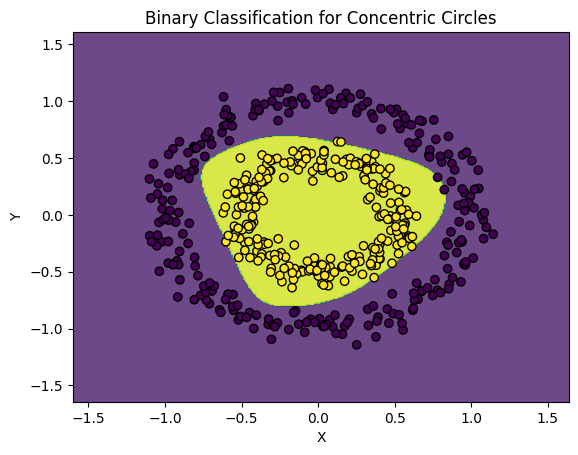

In [6]:
# Plot the decision boundary
x1_min, x1_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
x2_min, x2_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, 0.01), np.arange(x2_min, x2_max, 0.01))
Z = model(torch.tensor(np.c_[xx1.ravel(), xx2.ravel()], dtype=torch.float))
Z = (Z > 0.5).float().reshape(xx1.shape)

plt.contourf(xx1, xx2, Z, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y.squeeze(), edgecolors='k')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Binary Classification for Concentric Circles')
plt.show()

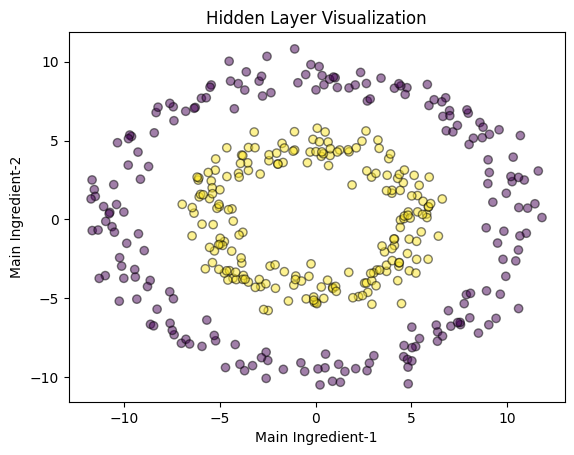

In [7]:
def visualize_hidden_layer(model, X, y):
    # 获取隐层的输出
    with torch.no_grad():
        hidden_layer_output = model.fc1(X).detach().numpy()
    
    # 使用PCA降维到二维空间
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(hidden_layer_output)

    # 绘制降维后的数据点
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=y.squeeze(), edgecolors='k', alpha=0.5)
    plt.title('Hidden Layer Visualization')
    plt.xlabel('Main Ingredient-1')
    plt.ylabel('Main Ingredient-2')
    plt.show()

# 可视化训练集的隐层数据分布
visualize_hidden_layer(model, X_train, y_train)


Epoch 250/120, Loss: 0.0181


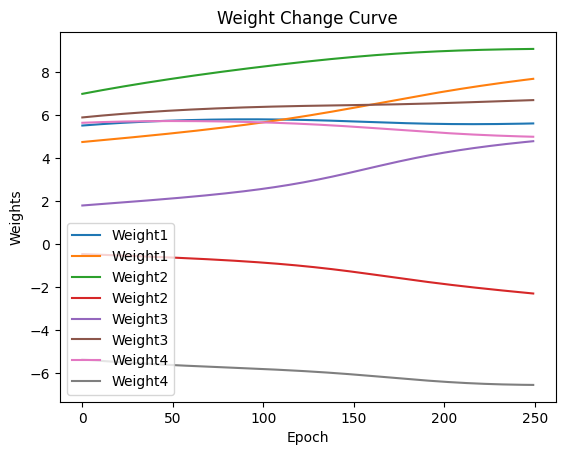

In [8]:
def visualize_weights(model, epochs=250):
    weights = []
    for epoch in range(epochs):
        # 记录权重
        weights.append(model.fc1.weight.data.numpy().copy())
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{120}, Loss: {loss.item():.4f}')
    
    # 将权重变化绘制成图
    weights = np.array(weights)
    for i in range(weights.shape[1]):
        plt.plot(weights[:, i], label=f'Weight{i+1}')
    plt.title('Weight Change Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Weights')
    plt.legend()
    plt.show()

# 可视化权重变化
visualize_weights(model)


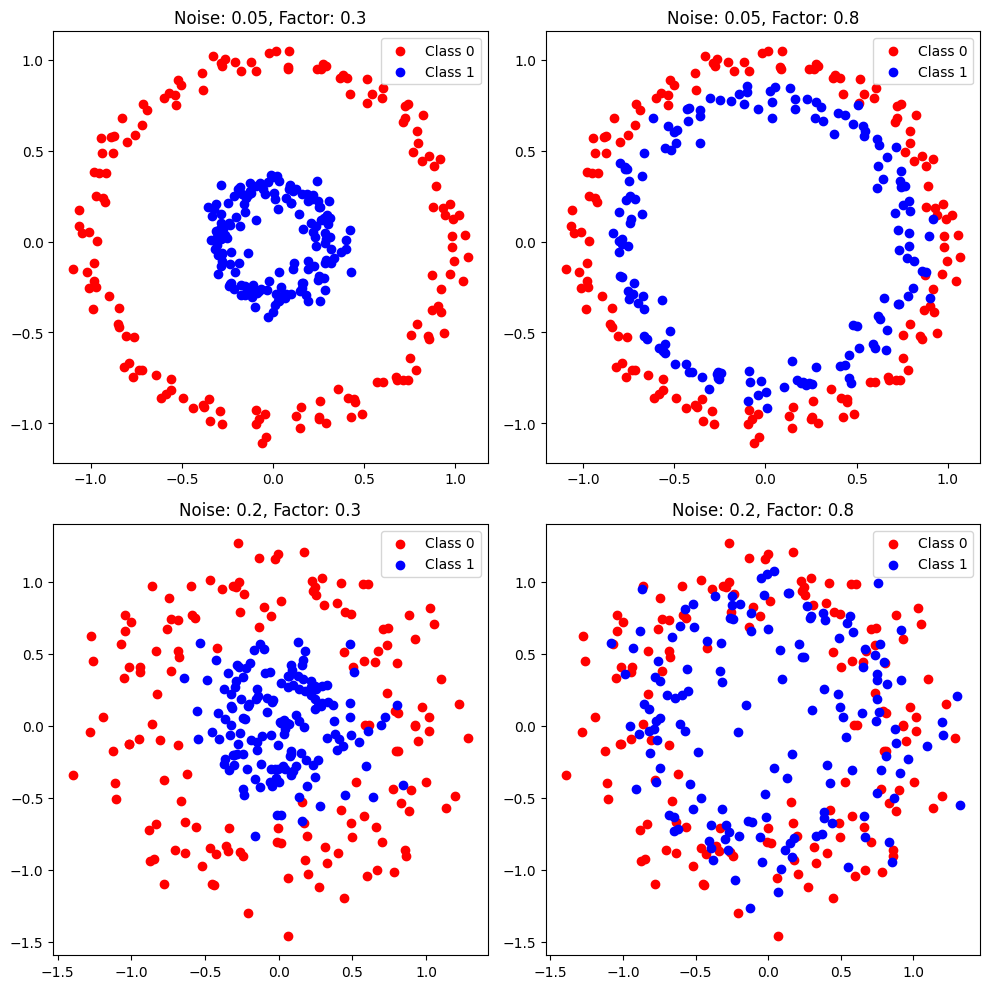

In [9]:
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt

# Function to create and plot circles with noise
def plot_circles(noise_level, factor, ax):
    # Generate the dataset with specified noise and factor
    X, y = make_circles(n_samples=300, factor=factor, noise=noise_level, random_state=42)

    # Scatter plot for class 0 and class 1
    ax.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='red', label='Class 0')
    ax.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='blue', label='Class 1')
    ax.set_title(f"Noise: {noise_level}, Factor: {factor}")
    ax.legend()

# Create figure with subplots for different noise levels and factors
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot 1: Low noise, small factor
plot_circles(0.05, 0.3, axs[0, 0])

# Plot 2: Low noise, large factor
plot_circles(0.05, 0.8, axs[0, 1])

# Plot 3: High noise, small factor
plot_circles(0.2, 0.3, axs[1, 0])

# Plot 4: High noise, large factor
plot_circles(0.2, 0.8, axs[1, 1])

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig('circles_dataset_examples.png')

# Show the plots
plt.show()


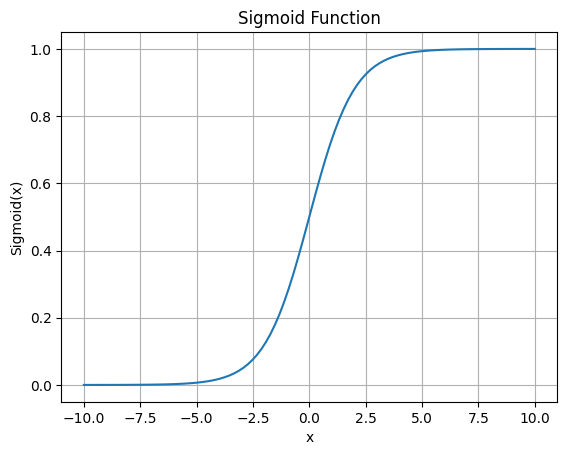

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Sigmoid函数定义
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# 创建一个数值范围
x = np.linspace(-10, 10, 100)
# 计算Sigmoid函数值
y = sigmoid(x)

# 绘制Sigmoid函数
plt.plot(x, y)
plt.title('Sigmoid Function')
plt.xlabel('x')
plt.ylabel('Sigmoid(x)')
plt.grid(True)
plt.show()


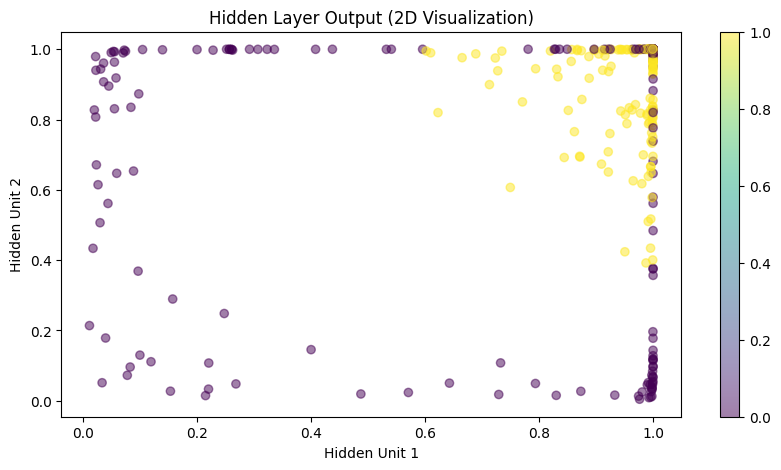

In [11]:
# 通过隐层传递输入数据并记录输出
def extract_hidden_layer_output(model, input_data):
    with torch.no_grad():
        hidden_layer_output = torch.sigmoid(model.fc1(input_data))
    return hidden_layer_output.numpy()

hidden_layer_output_train = extract_hidden_layer_output(model, X_train)
hidden_layer_output_test = extract_hidden_layer_output(model, X_test)

# 二维可视化
plt.figure(figsize=(10, 5))
plt.scatter(hidden_layer_output_train[:, 0], hidden_layer_output_train[:, 1], c=y_train.squeeze(), cmap='viridis', alpha=0.5)
plt.title('Hidden Layer Output (2D Visualization)')
plt.xlabel('Hidden Unit 1')
plt.ylabel('Hidden Unit 2')
plt.colorbar()
plt.show()


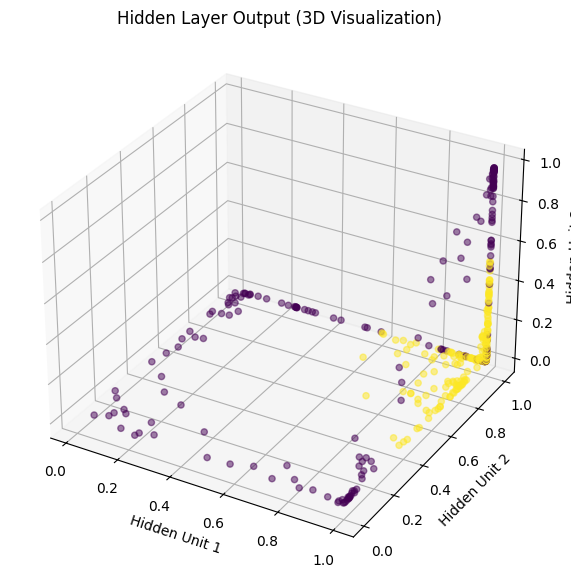

In [12]:
from mpl_toolkits.mplot3d import Axes3D

# 仅在隐层超过2个神经元时三维可视化才有意义
if hidden_layer_output_train.shape[1] > 2:
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(hidden_layer_output_train[:, 0], hidden_layer_output_train[:, 1], hidden_layer_output_train[:, 2], c=y_train.squeeze(), cmap='viridis', alpha=0.5)
    ax.set_title('Hidden Layer Output (3D Visualization)')
    ax.set_xlabel('Hidden Unit 1')
    ax.set_ylabel('Hidden Unit 2')
    ax.set_zlabel('Hidden Unit 3')
    plt.show()
